##### import необхідних бібліотек

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import time

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('GPU')
else:
  print('CPU')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

CPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Спрощені задачі

Розглянему спочатку більш прості варіанти завдання для кращого розуміння

##### Загальний клас нейромережі, що використовуватиметься в усіх наступних прикладах. Архітектура і параметри підбиратимуться окремо для кажної задачі

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, nn_arch):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(*self.init_layers(nn_arch))

    def init_layers(self, nn_arch):
        layers = []
        for item in nn_arch:
            if item[0] in activations:
                layers.append(activations[item[0]])
            else:
                layers.append(nn.Linear(item[0], item[1], bias=item[2]))

        return layers

    def forward(self, x):
        out = self.layers(x)

        return out

## $ y(x) $

Відновлення простої функціональної залежності на прикладі $ y = cos(x) $

##### Параметри моделі та інші змінні

In [ ]:
activations = {
    'relu': nn.ReLU(),
    'sigm': nn.Sigmoid()
}

nn_arch = [[1, 10, True], ['sigm'],
           [10, 1, False]]

num_epochs = 30000
show_every = 250
save_every = 10_000

batch_size = 8
learning_rate = 1.0e-4

results = {
    'epoch': [],
    'train dataset error': [],
    'test dataset error': [],
    'batch size': batch_size,
    'model state': {},
    'optim state': {}
}

##### Формуємо датасет

In [ ]:
class CosDataset(Dataset):
    def __init__(self, start_from=-8, density=40):
        t_arange = torch.arange(start_from, 8, 16 / density)
        self.x_data = t_arange.reshape((len(t_arange), 1))
        self.y_data = torch.cos(self.x_data)

        self.n_samples = np.shape(self.x_data)[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [ ]:
density = 100
train_dataset = CosDataset(density=density)
test_dataset = CosDataset(-8 + 16 / density, density=density)

results['dataset size'] = len(train_dataset)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

##### Агент

In [ ]:
class AgentCos:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=2000, gamma=0.88)

    def fit(self):
        for epoch in range(num_epochs):
            # fit loop
            for inputs, targets in self.dataset[0]:
                # Forward pass, loss
                outputs = self.model(inputs)
                loss = self.criterion(targets, outputs)

                # Backward and optimizer - calc grad and update weights
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.scheduler.step(epoch)

            # fit results
            if epoch == 0:
                self.calc_loss(epoch)

            if (epoch + 1) % show_every == 0:
                print(f"epoch #{epoch + 1} of {num_epochs} ({((epoch + 1) / num_epochs * 100):.2f}%)\n"
                      f"test dataset error: {results['test dataset error'][-1]}\n")
                self.calc_loss(epoch)

                # show results
                self.plt_loss()
                self.plt_graph()

            # if (epoch + 1) % save_every == 0:
            #     self.save_model()

    def calc_loss(self, epoch):
        train_loss, test_loss = [], []

        for inputs, targets in self.dataset[0]:
            outputs = self.model(inputs)
            train_loss.append(self.criterion(targets, outputs))

        for inputs, targets in self.dataset[1]:
            outputs = self.model(inputs)
            test_loss.append(self.criterion(targets, outputs))

        train_loss = torch.stack(train_loss)
        test_loss = torch.stack(test_loss)
        with torch.no_grad():
            results['epoch'].append(epoch + 1)
            results['train dataset error'].append(torch.mean(train_loss).item())
            results['test dataset error'].append(torch.mean(test_loss).item())

    def plt_loss(self):
        with torch.no_grad():
            ax_loss1.clear()

            ax_loss1.plot(results['epoch'], results['train dataset error'], color='blue')
            ax_loss1.plot(results['epoch'], results['test dataset error'], color='red')

            ax_loss1.legend(['train error', 'test error'])

            plt.tight_layout()
            plt.gcf().canvas.flush_events()

    def plt_graph(self):
        y_test_pred = {'xs': [], 'ys': []}
        for inputs, _ in self.dataset[1]:
            for element in inputs:
                y_test_pred['xs'].append(element[0].item())
                y_test_pred['ys'].append(self.model(element).item())

        with torch.no_grad():
            ax_graph.clear()

            # plot given data
            ax_graph.plot(torch.arange(-8, 8, 0.1), torch.cos(torch.arange(-8, 8, 0.1)),
                          color='blue', label='given datar')

            # plot model prediction on test dataset
            ax_graph.plot(y_test_pred['xs'], y_test_pred['ys'],
                          color='yellow', label='test dataset prediction')

            ax_graph.legend(['given data', 'test dataset prediction'])

            plt.tight_layout()
            plt.gcf().canvas.flush_events()

    def save_model(self):
        filename = 'models/model_cos' + ('%.3f' % results['test dataset error'][-1])

        results['model state'] = self.model.state_dict()
        results['optim state'] = self.optimizer.state_dict()

        torch.save(results, filename + '.pth')

        # Print results dict
        for key in results:
            print(f"{key}:\t{results[key]}\n")

    def load_model(self, filename):
        load_results = torch.load('models/' + filename + '.pth')
        for key in load_results:
            print(f"{key}:\t{load_results[key]}\n")

        self.model.load_state_dict(load_results['model state'])
        self.optimizer.load_state_dict(load_results['optim state'])

##### Тренування моделі

epoch #2500 of 30000 (8.33%)
test dataset error: 0.4831085205078125

epoch #5000 of 30000 (16.67%)
test dataset error: 0.030685970559716225

epoch #7500 of 30000 (25.00%)
test dataset error: 0.027447978034615517

epoch #10000 of 30000 (33.33%)
test dataset error: 0.0038366252556443214

epoch #12500 of 30000 (41.67%)
test dataset error: 0.0015212972648441792

epoch #15000 of 30000 (50.00%)
test dataset error: 0.0002167312486562878

epoch #17500 of 30000 (58.33%)
test dataset error: 0.0001128984586102888

epoch #20000 of 30000 (66.67%)
test dataset error: 0.0004193111672066152

epoch #22500 of 30000 (75.00%)
test dataset error: 0.00019082470680586994

epoch #25000 of 30000 (83.33%)
test dataset error: 5.13734994456172e-05

epoch #27500 of 30000 (91.67%)
test dataset error: 0.0001003521028906107

epoch #30000 of 30000 (100.00%)
test dataset error: 0.00019342407176736742


epoch: 30000

train dataset error: 4.824404459213838e-05

test dataset error: 4.6865832700859755e-05


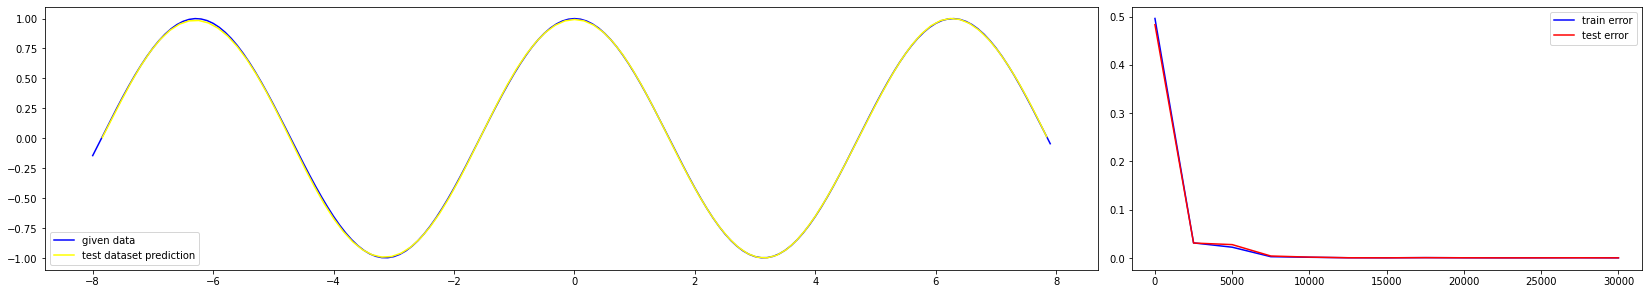

In [ ]:
fig = plt.figure(figsize=(23, 8))
gs = GridSpec(ncols=3, nrows=2, figure=fig)
ax_graph = plt.subplot(gs[0:2])
ax_loss1 = plt.subplot(gs[2])

model = NeuralNet(nn_arch)
agent = AgentCos(model, (train_loader, test_loader))

agent.fit()

for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")

##### Висновки

(1) Провівши серію тренувань моделі з різними параметрами було виявлено, що при розмірі датасета < 15 (тобто, 6 точок на кожен проміжок довжиною $ 2\pi $), деякі частини графіка апроксимуються неточно: нейромережа "запам'ятовує" окремі точки, а не намагається "зрозуміти" залежність між змінними в цілому. Тому важливо, щоб датасет містив достатню кількість даних

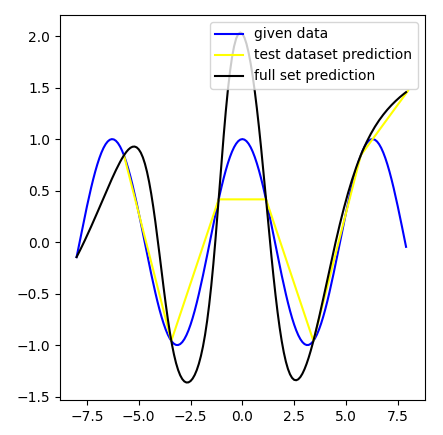

(2) Якщо тестову вибірку формувати не випадково по всьому діапазону, а взяти певний зріз (наприклад, $ train \in [-8, 5],\ test \in [5, 8] $), нейромережа навчиться працювати з тренувальною вибіркою, проте буде діяти зовсім випадково на тестовій

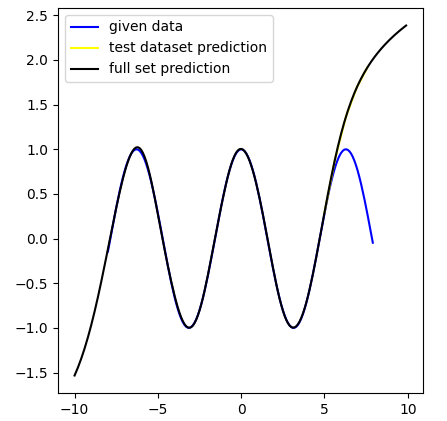

(3) Мінімальна кількість нейронів, необхідна для досить точної апроксимації - 6

## $ y(x_1, x_2) $

Ускладнимо задачу, додавши один вимір

Для імітації реальної задачі візьмемо функцію

$ \text{harvest loss} = \min\left\{0.9 * |wetness - 100| + 0.6 * |index - 100|,\ 100\right\},\\ wetness \in  [0, 200],\ index \in [0, 100] $

Де $ wetness $ - показник вологості поля, $ index $ - деякий індекс, що вказує на якість ґрунту

Таким чином, при $ wetness = 0 $ або $ wetness = 200 $ втрати становитимуть мінімум 90 %. Оптимальна вологість - 100

При index = 0 втрати врожаю становитимуть від 60%

##### Параметри моделі та інші змінні

In [ ]:
activations = {
    'relu': nn.ReLU(),
    'sigm': nn.Sigmoid()
}

nn_arch = [[2, 70, True], ['sigm'],
           [70, 1, False]]

num_epochs = 75_000
show_every = 7500
save_every = 5000

batch_size = 256
learning_rate = 2.0e-4

results = {
    'epoch': [],
    'train dataset error': [],
    'test dataset error': [],
    'batch size': batch_size,
    'model state': {},
    'optim state': {},
    'dataset size': 0
}

##### Формуємо датасет

In [ ]:
class WIDataset(Dataset):

    def __init__(self, start_from=0, density=40):
        self.x_data = self.init_x_data(start_from, density)
        self.y_data = self.init_y_data()

        self.n_samples = np.shape(self.x_data)[0]

    def init_x_data(self, start_from, density):
        x_data = []

        for w in torch.arange(start_from, 201, 100 / density, dtype=torch.float32):
            for i in torch.arange(start_from, 101, 100 / density, dtype=torch.float32):
                x_data.append(torch.stack([w, i]))

        x_data = torch.stack(x_data)

        return x_data

    def init_y_data(self):
        y_data = []

        for item in self.x_data:
            y_data.append(self.h_loss_function(*item))

        return y_data

    def h_loss_function(self, wetness, index):
        return torch.min(torch.tensor([0.9 * abs(wetness - 100) + 0.6 * (100 - index)]), torch.tensor([100.0]))

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [ ]:
density = 15
train_dataset = WIDataset(density=density)
test_dataset = WIDataset(100 / (2 * density), density=density)

results['dataset size'] = len(train_dataset)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

##### Агент

In [ ]:
class AgentWI:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=2000, gamma=0.9)

    def fit(self):
        for epoch in range(num_epochs):
            # fit loop
            for inputs, targets in self.dataset[0]:
                # Forward pass, loss
                outputs = self.model(inputs)
                loss = self.criterion(targets, outputs)

                # Backward and optimizer - calc grad and update weights
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.scheduler.step(epoch)

            # fit results
            if epoch == 0:
                self.calc_loss(epoch)

            if (epoch + 1) % show_every == 0:
                print(f"epoch #{epoch + 1} of {num_epochs} ({((epoch + 1) / num_epochs * 100):.2f}%)\n"
                      f"test dataset error: {results['test dataset error'][-1]}\n")
                self.calc_loss(epoch)

                # show results
                self.plt_loss()
                self.plt_3d()
                
                # save current state dict
                results['model state'] = self.model.state_dict()
                results['optim state'] = self.optimizer.state_dict()

            # if (epoch + 1) % save_every == 0:
            #     self.save_model()

    def calc_loss(self, epoch):
        train_loss, test_loss = [], []

        for inputs, targets in self.dataset[0]:
            outputs = self.model(inputs)
            train_loss.append(self.criterion(targets, outputs))

        for inputs, targets in self.dataset[1]:
            outputs = self.model(inputs)
            test_loss.append(self.criterion(targets, outputs))

        train_loss = torch.stack(train_loss)
        test_loss = torch.stack(test_loss)
        with torch.no_grad():
            results['epoch'].append(epoch + 1)
            results['train dataset error'].append(torch.sqrt(torch.mean(train_loss)).item())
            results['test dataset error'].append(torch.sqrt(torch.mean(test_loss)).item())

    def forward_pass(self):
        # model prediction on train dataset
        y_train_pred = {'xs': [], 'ys': [], 'zs': []}
        for inputs, _ in self.dataset[0]:
            for element in inputs:
                y_train_pred['xs'].append(element[0].item())
                y_train_pred['ys'].append(element[1].item())
                y_train_pred['zs'].append(self.model(element).item())

        # model prediction on test dataset
        y_test_pred = {'xs': [], 'ys': [], 'zs': []}
        for inputs, _ in self.dataset[1]:
            for element in inputs:
                y_test_pred['xs'].append(element[0].item())
                y_test_pred['ys'].append(element[1].item())
                y_test_pred['zs'].append(self.model(element).item())

        return y_train_pred, y_test_pred

    def plt_loss(self):
        with torch.no_grad():
            ax_loss1.clear()

            ax_loss1.plot(results['epoch'], results['train dataset error'], color='blue')
            ax_loss1.plot(results['epoch'], results['test dataset error'], color='red')

            ax_loss1.legend(['train error', 'test error'])

            plt.gcf().canvas.flush_events()

    def dataset_plt(self):
        wet = np.arange(0, 200, 5)
        index = np.arange(0, 100, 5)
        xgrid, ygrid = np.meshgrid(wet, index)

        zgrid = 0.9 * abs(xgrid - 100) + 0.6 * (100 - ygrid)
        for d1_index in range(len(zgrid)):
            for d2_index in range(len(zgrid[0])):
                if zgrid[d1_index, d2_index] > 100:
                    zgrid[d1_index, d2_index] = 100

        return xgrid, ygrid, zgrid

    def plt_3d(self, show_given=True, show_train=False, show_test=True):
        y_train_pred, y_test_pred = self.forward_pass()

        with torch.no_grad():
            ax_3d.clear()
            ax_3d.set_xlabel('wet')
            ax_3d.set_ylabel('index')
            ax_3d.set_zlabel('harvest loss')

            # plot given data
            if show_given:
                ax_3d.plot_wireframe(* self.dataset_plt(), color='b')

            # plot model prediction on train dataset
            if show_train:
                ax_3d.scatter(y_train_pred['xs'], y_train_pred['ys'], y_train_pred['zs'], c='r', s=20)

            # plot model prediction on test dataset
            if show_test:
                ax_3d.scatter(y_test_pred['xs'], y_test_pred['ys'], y_test_pred['zs'], c='y', s=20)

            plt.gcf().canvas.flush_events()

    def save_model(self):
        filename = 'models/model_wi' + ('%.1f' % results['test dataset error'][-1])

        results['model state'] = self.model.state_dict()
        results['optim state'] = self.optimizer.state_dict()

        torch.save(results, filename + '.pth')

        # Print results dict
        for key in ['epoch', 'train dataset error', 'test dataset error']:
            print(f"{key}:\t{results[key][-1]}")
        print(f"batch size:\t{results['batch size']}\n"
              f"optim state:\t{results['optim state']}\n")

    def load_model(self, filename):
        load_results = torch.load('models/' + filename + '.pth')
        for key in load_results:
            print(f"{key}:\t{load_results[key]}\n")

        self.model.load_state_dict(load_results['model state'])
        self.optimizer.load_state_dict(load_results['optim state'])

##### Тренування моделі

epoch #7500 of 75000 (10.00%)
test dataset error: 74.32083129882812



/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


epoch #15000 of 75000 (20.00%)
test dataset error: 17.316062927246094

epoch #22500 of 75000 (30.00%)
test dataset error: 15.591164588928223

epoch #30000 of 75000 (40.00%)
test dataset error: 13.941398620605469

epoch #37500 of 75000 (50.00%)
test dataset error: 13.306794166564941

epoch #45000 of 75000 (60.00%)
test dataset error: 11.666960716247559

epoch #52500 of 75000 (70.00%)
test dataset error: 13.395410537719727

epoch #60000 of 75000 (80.00%)
test dataset error: 10.165132522583008

epoch #67500 of 75000 (90.00%)
test dataset error: 10.279098510742188

epoch #75000 of 75000 (100.00%)
test dataset error: 5.964016914367676

epoch:	75000
train dataset error:	6.099709987640381
test dataset error:	5.818264484405518


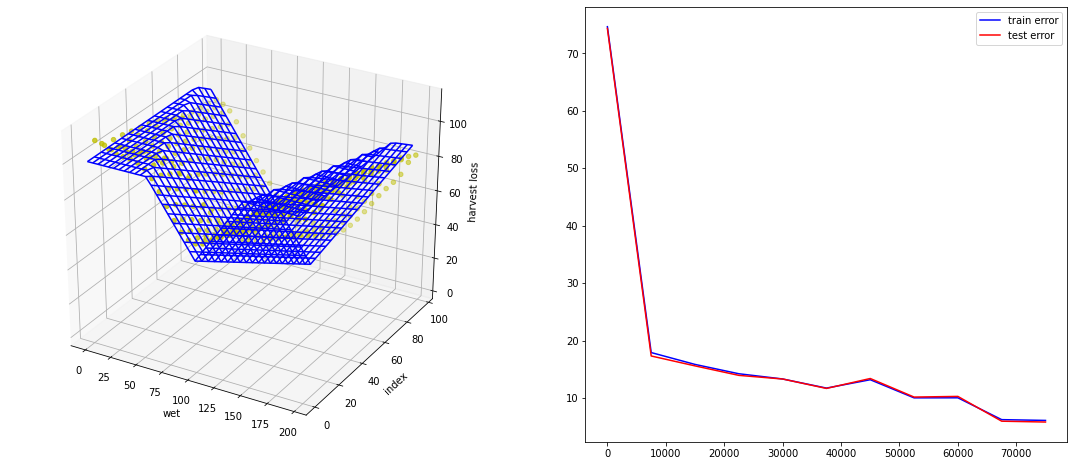

In [ ]:
fig = plt.figure(figsize=(19, 8))
ax_3d = fig.add_subplot(1, 2, 1, projection='3d', zlim3d=[-20.0, 120.0])
ax_loss1 = fig.add_subplot(1, 2, 2)

model = NeuralNet(nn_arch)
agent = AgentWI(model, (train_loader, test_loader))

agent.fit()

for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")

##### Висновки

(1) Мінімальний розмір датасета для досить точної апроксимації даною нейромережею - 250

Похибку більше 3 вважатимемо суттєвою, адже слід враховувати, що в даному прикладі однозначно визначена функціональна залежність без шумів, викидів та випадкових відхилень, що зустрічатимуться у реальному датасеті. Якщо в ідеальних умовах похибка більше 3, в реальних вона буде ще більшою, прогнозування буде занадто неточним

(2) За 75 000 епох вдалось досягти середнього відхилення $ \sim $6. Якщо продовжити навчання, можна зменшити його до 1, а при більшому розмірі датасету воно прямуватиме до 0, але навчатиметься модель довше. На жаль, виділені потужності безкоштовного колабу занадто обмежені, щоб це перевірити :)

(3) Можливо, тренування відбувається недостатьно швидко через обрану модель та може бути оптимізовано

# Основна задача

## EDA

Реальний датасет та його залежності значно складніші, ніж в простих прикладах, наведених вище. Проведемо спочатку EDA для кращого розуміння даних та виявлення цікавих деталей

##### na значення

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Syngenta/dataset.csv')
print(f"df size: {df.shape}")

df size: (56, 34)


In [ ]:
df.head()

,Unnamed: 0,№,region,district,locality,hybrid,seeding_date,desication_date,harvesting_date,prodactivity_c/hec,seed_circle_moisture_%,seed_specific_weight_kg/HL,zone,index,mean_index_FarmShots,frame_number,frame_square_m^2,account_frames_area_m^2,total_frame_loss_g,loss_g/m^2,loss_g/hec,loss_kg/hec,2.5,loss_%/hec,seed_moisture_%,field_square,field_square_percent_%,number_of_hectares_of_the_total_area,prodactivity_kg/hec,loss_kg,total_field_loss,Unnamed: 30,"coef_2,5",2.5.1
0,0,1,Луганська обл.,Троїцький,Караїчне,Peeoner,NaN,2021-08-25 00:00:00,2021-09-05,27.5,9.8,36.6,Десикація 10 л/га.,NaN,NaN,11,0.1,1.1,0.90,0.818182,8181.818182,8.181818,NaN,0.297521,9.3,3.8,100.0,3.800,2750,31.090909,NaN,NaN,20.454545,NaN
1,1,1,Луганська обл.,Троїцький,Караїчне,Peeoner,NaN,2021-08-25 00:00:00,2021-09-05,27.5,9.8,36.6,"Десикація 3,5 л/га.",NaN,NaN,11,0.1,1.1,0.95,0.863636,8636.363636,8.636364,NaN,0.314050,9.4,1.3,100.0,1.300,2750,11.227273,NaN,NaN,28.068182,NaN
2,2,1,Луганська обл.,Троїцький,Караїчне,Peeoner,NaN,NaN,2021-09-05,27.5,9.8,36.6,Червона зона,"0,16-0,25",0.267,11,0.1,1.1,2.04,1.854545,18545.454545,18.545455,NaN,0.674380,12.1,21.0,13.7,2.877,2750,53.355273,NaN,NaN,133.388182,NaN
3,3,1,Луганська обл.,Троїцький,Караїчне,Peeoner,NaN,NaN,2021-09-05,27.5,9.8,36.6,Жовта зона,"0,25-0,28",0.267,11,0.1,1.1,3.02,2.745455,27454.545455,27.454545,NaN,0.998347,12.7,21.0,79.7,16.737,2750,459.506727,NaN,NaN,1148.766818,NaN
4,4,1,Луганська обл.,Троїцький,Караїчне,Peeoner,NaN,NaN,2021-09-05,27.5,9.8,36.6,Зелена зона,"0,28-0,34",0.267,11,0.1,1.1,2.83,2.572727,25727.272727,25.727273,NaN,0.935537,12.2,21.0,6.0,1.260,2750,32.416364,587.596545,NaN,81.040909,NaN


na значеня в датасеті

In [ ]:
df.isna().sum().sort_values(ascending=False)

2.5.1                                   56
2.5                                     56
Unnamed: 30                             56
seeding_date                            52
desication_date                         50
total_field_loss                        39
seed_specific_weight_kg/HL              36
hybrid                                  33
locality                                27
district                                27
harvesting_date                         21
mean_index_FarmShots                     8
index                                    3
coef_2,5                                 0
loss_kg                                  0
prodactivity_kg/hec                      0
number_of_hectares_of_the_total_area     0
field_square_percent_%                   0
field_square                             0
seed_moisture_%                          0
loss_%/hec                               0
Unnamed: 0                               0
loss_kg/hec                              0
loss_g/hec 

Одразу видалимо поля, що містять багато na значень

Також видалимо поле №, оскільки воно лише вказує на те, що дослідження проведено в одній області. Цю задачу вже виконує поле region

In [ ]:
df = df.drop(['2.5.1', '2.5', '№', 'Unnamed: 0', 'Unnamed: 30', 'seeding_date', 'desication_date', 'total_field_loss',
              'seed_specific_weight_kg/HL', 'hybrid', 'locality', 'district', 'harvesting_date'], axis=1)

Колонку index розіб'ємо на 2 для зручності

In [ ]:
df[['index_0', 'index_1']] = df['index'].str.split('-', expand=True)
df[['index_0', 'index_1']] = df[['index_0', 'index_1']].apply(lambda x: x.str.replace(',','.')).astype(float)

df = df.drop(['index'], axis=1)

na значення, що залишились, замінимо на середні по всій вибірці

In [ ]:
mean_farmshots = df[df['mean_index_FarmShots'].notna()]['mean_index_FarmShots'].mean()
mean_index0 = df[df['index_0'].notna()]['index_0'].mean()
mean_index1 = df[df['index_1'].notna()]['index_1'].mean()

df['mean_index_FarmShots'] = df['mean_index_FarmShots'].fillna(mean_farmshots)
df['index_0'] = df['index_0'].fillna(mean_index0)
df['index_1'] = df['index_1'].fillna(mean_index1)

##### Видалення зайвого

Поле frame_square_m^2 містить однакові значення в кожному рядку, тому в ньому немає корисної інформації, що може вплинути на тренування моделі

In [ ]:
df = df.drop(['frame_square_m^2'], axis=1)

Видалимо колонки, в яких повторюється інформація. Наприклад, loss_g/m^2 і loss_g/hec (змінюється лише розмірність)

In [ ]:
df = df.drop(['loss_g/m^2', 'loss_g/hec', 'prodactivity_kg/hec'], axis=1)

Областей в датасеті багато, дореченіше буде надати кожній експертну оцінку, сформувати рейтинг, ніж випадково призначати певне число (текстову назву модель не зрозуміє, дані мають бути числовими)

In [ ]:
df = df.drop(['region'], axis=1)

При тренуванні моделі виявлено, що поле zone погіршує точність. Можна також скористатись експертною оцінкою замість випадкового призначення чисел

In [ ]:
df = df.drop(['zone'], axis=1)

##### Кореляції

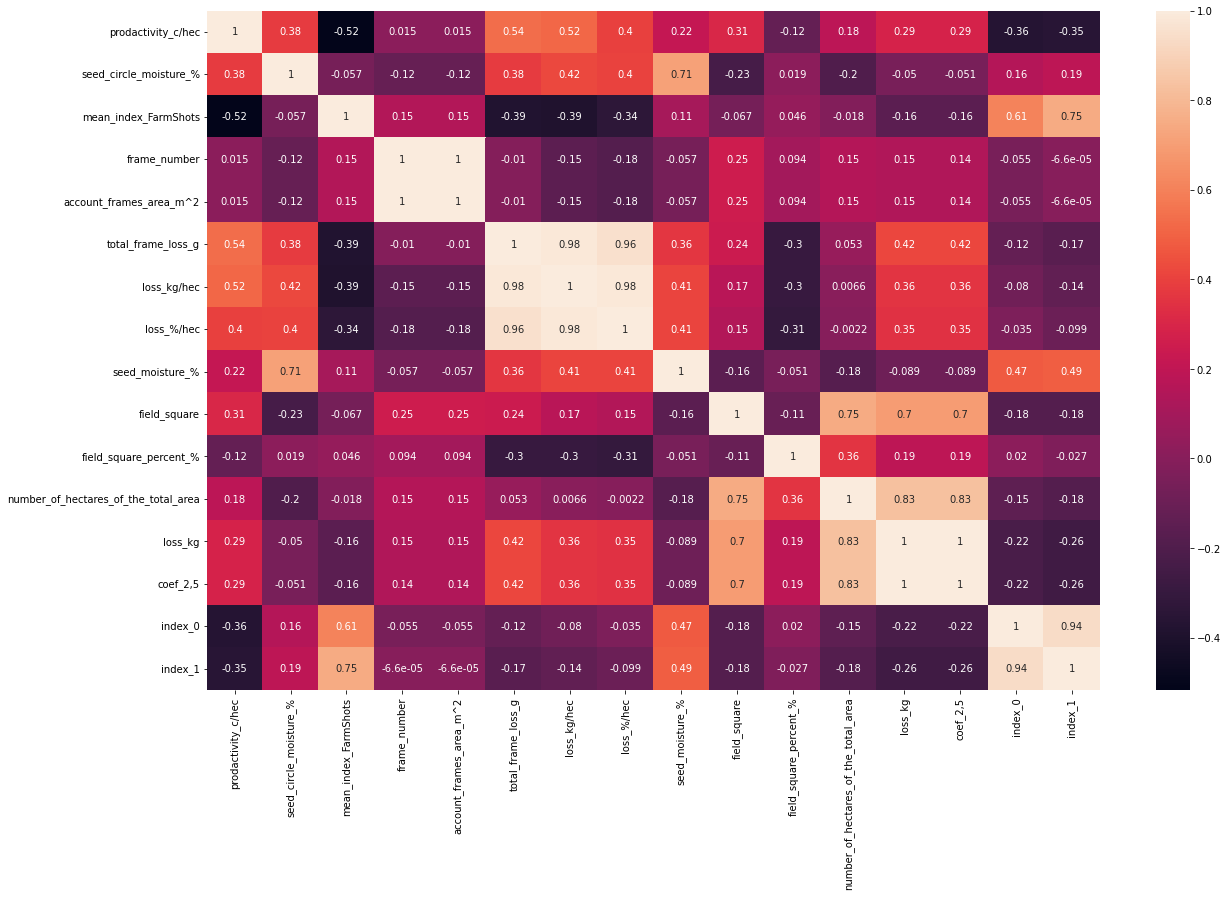

In [ ]:
fig=plt.figure(figsize=(20, 12.5))
sns.heatmap(df.corr(),annot=True)

Відкинемо дані, що слабко корелюють з іншими, щоб зручніше було розглянути сильні залежності

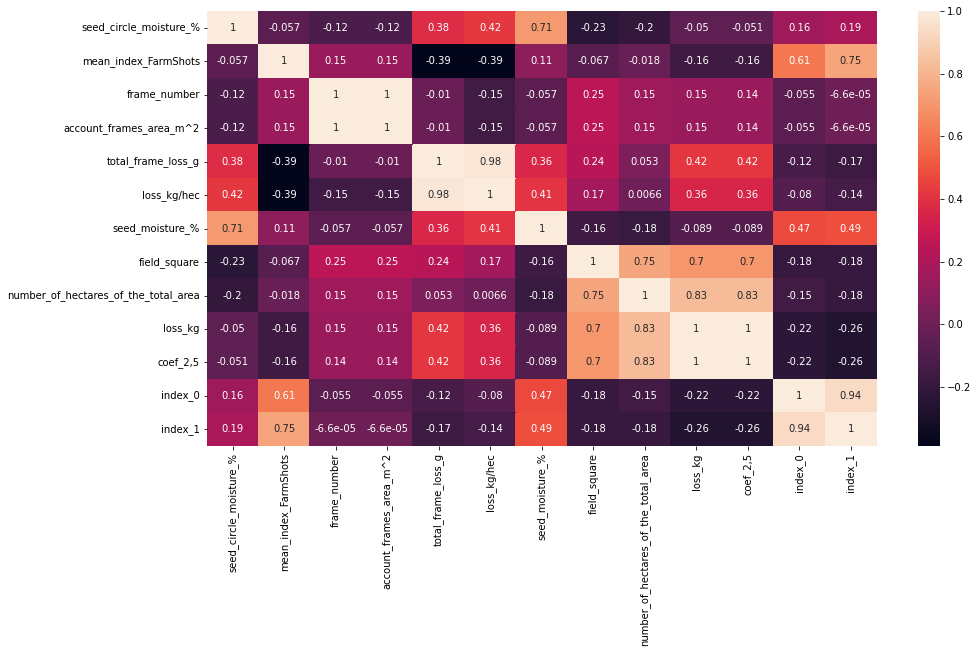

In [ ]:
df_subset = df.drop(['prodactivity_c/hec', 'loss_%/hec', 'field_square_percent_%'], axis=1)

fig=plt.figure(figsize=(15, 8))
sns.heatmap(df_subset.corr(),annot=True)

Різні показники вологості насіння сильно корелюють між собою, що логічно, адже вимірюється один і той самий параметр різними методами

mean_index_FarmShots сильно корелює з index_0 та index_1

Кореляція між frame_number і account_frames_ares_m^2 = 1

Кореляція між total_frame_loss_g та loss_kg/hec становить 0,98. Отже між ними майже пряма залежність, можна видалити одне з них при тренуванні моделі

Від площі поля сильно залежать втрати (в кг), що логічно

index_0 та index_1 сильно корелюють, оскільки це один показник з невеликим діапазоном, розділений на 2 поля

Кореляція між coef_2,5 і loss_kg = 1. Розглянему цю пару далі

Дійсно, loss kg в середньому в 11 разів більше за total loss, проте різниця є, тому слід розглянути обидва варіанти при тренуванні моделі (з обома полями та з видаленням одного з них)

In [ ]:
corr_total_loss = df[['total_frame_loss_g', 'loss_kg/hec']].sort_values(by='loss_kg/hec')
corr_total_loss['loss kg / total loss'] = corr_total_loss['loss_kg/hec'] / corr_total_loss['total_frame_loss_g']

corr_total_loss.head(10)

,total_frame_loss_g,loss_kg/hec,loss kg / total loss
21,0.10,1.250000,12.500000
22,0.20,2.500000,12.500000
30,0.50,5.000000,10.000000
0,0.90,8.181818,9.090909
1,0.95,8.636364,9.090909
29,1.10,11.000000,10.000000
17,1.10,13.750000,12.500000
25,1.20,15.000000,12.500000
13,1.50,15.000000,10.000000
52,1.60,16.000000,10.000000


Площа в 10 разів менша за кількість рамок, оскільки площа однієї рамки = 0.1 m^2 у кожному рядку. Використовуватимемо тільки frame_number, account_frames_area_m^2 видалимо

In [ ]:
corr_frame = df[['frame_number', 'account_frames_area_m^2']].sort_values(by='account_frames_area_m^2')
corr_frame['frame number / area'] = corr_frame['frame_number'] / corr_frame['account_frames_area_m^2']

corr_frame.tail(10)

,frame_number,account_frames_area_m^2,frame number / area
28,10,1.0,10.0
29,10,1.0,10.0
30,10,1.0,10.0
31,10,1.0,10.0
15,10,1.0,10.0
4,11,1.1,10.0
3,11,1.1,10.0
2,11,1.1,10.0
1,11,1.1,10.0
0,11,1.1,10.0


In [ ]:
df = df.drop(['account_frames_area_m^2'], axis=1)

Між coef_2,5 та loss_kg пряма залежність: коефіцієнт в 2.5 рази більший за втрати. Залежність не працює лише в одному рядку. Скоріш за все, сталась помилка при внесенні даних, видалимо цей рядок. При тренуванні використовуватимемо лише втрати(кг), поле coef_2,5 видалимо

In [ ]:
corr_loss = df[['loss_kg', 'coef_2,5']].sort_values(by='loss_kg')
corr_loss['coef / loss'] =  corr_loss['coef_2,5'] / corr_loss['loss_kg']

corr_loss.head(10)

,loss_kg,"coef_2,5",coef / loss
13,0.615600,1.539000,2.500000
22,4.416400,11.041000,2.500000
55,4.685400,11.713500,2.500000
1,11.227273,28.068182,2.500000
21,15.222100,38.055250,2.500000
20,15.403100,38.507750,2.500000
0,31.090909,20.454545,0.657895
4,32.416364,81.040909,2.500000
2,53.355273,133.388182,2.500000
52,87.225600,218.064000,2.500000


In [ ]:
df = df.drop(0, axis=0).reset_index(drop=True)
df = df.drop(['coef_2,5'], axis=1)
df.shape

(55, 14)

##### Викиди

Перевіримо, чи є в даних викиди

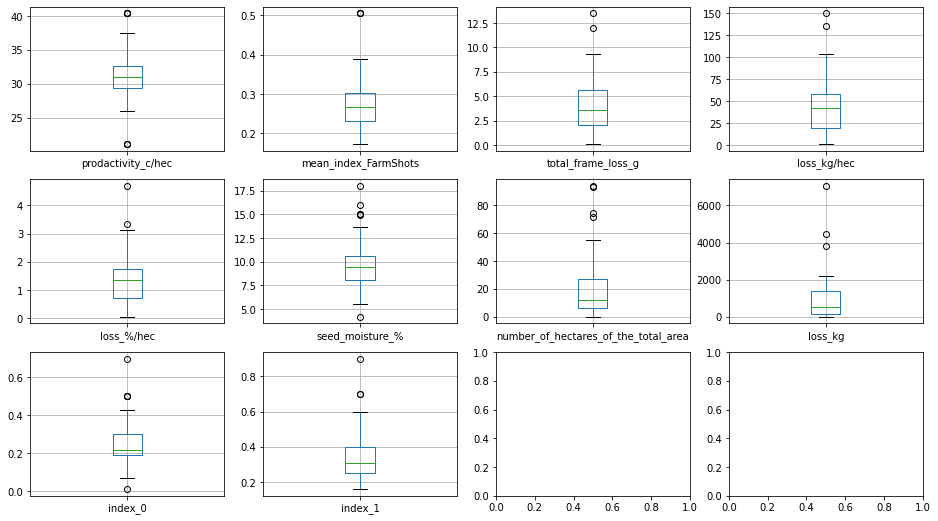

In [ ]:
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(16, 9)

df_subset = df[['prodactivity_c/hec', 'mean_index_FarmShots', 'total_frame_loss_g',
                'loss_kg/hec', 'loss_%/hec', 'seed_moisture_%',
                'number_of_hectares_of_the_total_area', 'loss_kg', 'index_0', 'index_1']]

for i, el in enumerate(df_subset.columns):
    df_subset.boxplot(el, ax=axes.flatten()[i])

Записи, що містять найбільше викидів

In [ ]:
df.iloc[[4, 5, 6, 19, 20, 21, 7, 43, 27, 32, 33]]

,prodactivity_c/hec,seed_circle_moisture_%,mean_index_FarmShots,frame_number,total_frame_loss_g,loss_kg/hec,loss_%/hec,seed_moisture_%,field_square,field_square_percent_%,number_of_hectares_of_the_total_area,loss_kg,index_0,index_1
4,40.41,10.1,0.212000,10,6.00,60.000000,1.484781,9.5,100.40,10.00,10.07000,602.400000,0.13,0.19
5,40.41,10.1,0.212000,9,3.75,41.666667,1.031098,10.8,100.40,28.67,28.78468,1199.361667,0.13,0.19
6,40.41,10.1,0.212000,8,2.78,34.750000,0.859936,10.5,100.40,54.94,55.15976,1916.801660,0.19,0.22
19,21.10,8.0,0.302000,8,2.30,28.750000,1.362559,5.5,14.48,3.70,0.53576,15.403100,0.22,0.25
20,21.10,8.0,0.302000,8,0.10,1.250000,0.059242,6.5,14.48,84.10,12.17768,15.222100,0.25,0.34
21,21.10,8.0,0.302000,8,0.20,2.500000,0.118483,8.0,14.48,12.20,1.76656,4.416400,0.34,0.43
7,40.41,10.1,0.212000,10,13.50,135.000000,3.340757,13.1,100.40,16.31,16.37524,2210.657400,0.22,0.34
43,32.00,12.4,0.275146,8,12.00,150.000000,4.687500,18.0,40.00,8.90,3.56000,534.000000,0.43,0.52
27,31.00,8.0,0.290000,10,7.50,75.000000,2.419355,7.3,190.87,49.30,94.09891,7057.418250,0.19,0.25
32,32.20,9.4,0.255000,10,4.80,48.000000,1.490683,9.7,181.90,51.25,93.22375,4474.740000,0.20,0.30


Видалимо рядки, що містять найбільші викиди

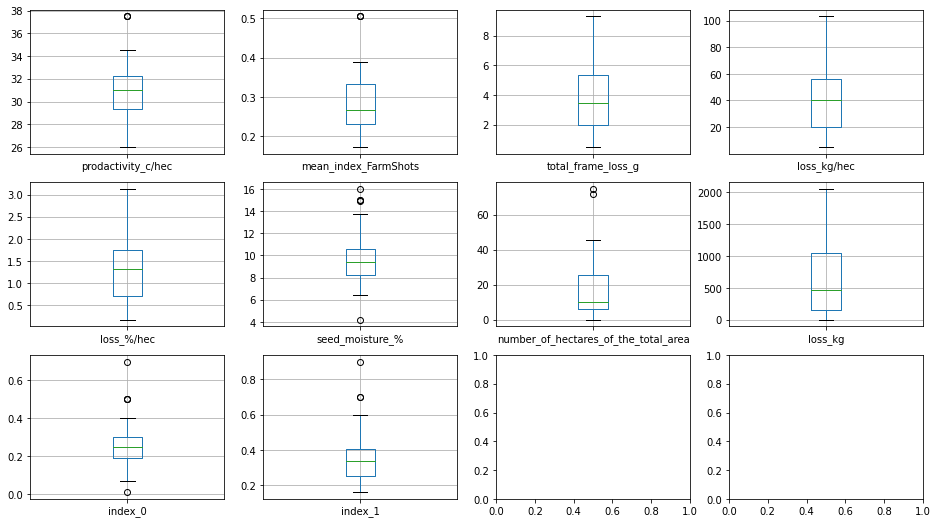

In [ ]:
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(16, 9)

df_subset = df[['prodactivity_c/hec', 'mean_index_FarmShots', 'total_frame_loss_g',
                'loss_kg/hec', 'loss_%/hec', 'seed_moisture_%',
                'number_of_hectares_of_the_total_area', 'loss_kg', 'index_0', 'index_1']]

df_subset = df_subset.drop([4, 5, 6, 19, 20, 21, 7, 43, 27, 32, 33], axis=0)

for i, el in enumerate(df_subset.columns):
    df_subset.boxplot(el, ax=axes.flatten()[i])

Як видно з графіків, видалення попередніх викидів призводить до появи нових. Це пояснюється тим, що даних небагато, та вони розташовані нещільно. Також експериментально виявлено, що видалення цих даних призводить до значного збільшення похибки при тренуванні моделі

Тому єдиний вихід для покращення результатів моделі - збір нових даних для заповнення проміжків

## Повнозв'язна нейромережа

Спробуємо застосувати модель, що була використана вище

Для зручності змінимо порядок колонок датасету

In [ ]:
df = df[['seed_circle_moisture_%', 'seed_moisture_%', 'frame_number', 'field_square',
         'field_square_percent_%', 'number_of_hectares_of_the_total_area', 'mean_index_FarmShots', 'index_0', 'index_1',
         'prodactivity_c/hec', 'total_frame_loss_g', 'loss_kg/hec', 'loss_%/hec', 'loss_kg']]

df.head()

,seed_circle_moisture_%,seed_moisture_%,frame_number,field_square,field_square_percent_%,number_of_hectares_of_the_total_area,mean_index_FarmShots,index_0,index_1,prodactivity_c/hec,total_frame_loss_g,loss_kg/hec,loss_%/hec,loss_kg
0,9.8,9.4,11,1.3,100.0,1.300,0.275146,0.248679,0.34566,27.50,0.95,8.636364,0.314050,11.227273
1,9.8,12.1,11,21.0,13.7,2.877,0.267000,0.160000,0.25000,27.50,2.04,18.545455,0.674380,53.355273
2,9.8,12.7,11,21.0,79.7,16.737,0.267000,0.250000,0.28000,27.50,3.02,27.454545,0.998347,459.506727
3,9.8,12.2,11,21.0,6.0,1.260,0.267000,0.280000,0.34000,27.50,2.83,25.727273,0.935537,32.416364
4,10.1,9.5,10,100.4,10.0,10.070,0.212000,0.130000,0.19000,40.41,6.00,60.000000,1.484781,602.400000


##### Параметри моделі та інші змінні

In [ ]:
activations = {
    'relu': nn.ReLU(),
    'sigm': nn.Sigmoid()
}

nn_arch = [[9, 150, True], ['sigm'],
           [150, 1, False]]

num_epochs = 17_500
show_every = 1750
save_every = 50_000

learning_rate = 1.0e-7
batch_size = 8

target = 'loss_kg/hec'
results = {
    'target': '',
    'epoch': [],
    'train dataset error': [],
    'test dataset error': [],
    'batch size': batch_size,
    'model state': {},
    'optim state': {},
    'dataset size': 0
}

##### Формуємо датасети

Кожну таргет змінну будемо прогнозувати окремо

In [ ]:
df_inputs = df.drop(['prodactivity_c/hec', 'total_frame_loss_g',
                     'loss_kg/hec', 'loss_%/hec', 'loss_kg'], axis=1)


class FieldDesDataset(Dataset):
    def __init__(self, target, test=False):
        x_data = df_inputs
        y_data = df[target]

        test_slice = int(len(df) * 0.2)
        if test:
            x_data = x_data.iloc[-test_slice:, :]
            y_data = y_data.iloc[-test_slice:]
        else:
            x_data = x_data.iloc[:-test_slice, :]
            y_data = y_data.iloc[:-test_slice]

        self.x_data = torch.tensor(x_data.values, dtype=torch.float32)
        self.y_data = torch.tensor(y_data.values, dtype=torch.float32).unsqueeze(1)

        self.n_samples = np.shape(self.x_data)[0]

    def __getitem__(self, index):
        return self.x_data[index, :], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [ ]:
def form_dataset(target, to_drop=None, batch_size=4):
    train_dataset = FieldDesDataset(target)
    test_dataset = FieldDesDataset(target, test=True)

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

    return train_loader, test_loader

##### Агент

In [ ]:
class AgentFieldDes:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=2500, gamma=1)

    def fit(self):
        for epoch in range(num_epochs):
            # fit loop
            for inputs, targets in self.dataset[0]:
                # Forward pass, loss
                outputs = self.model(inputs)
                loss = self.criterion(targets, outputs)

                # Backward and optimizer - calc grad and update weights
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.scheduler.step(epoch)

            # fit results
            if epoch == 0:
                self.calc_loss(epoch)

            if (epoch + 1) % show_every == 0:
                print(f"epoch #{epoch + 1} of {num_epochs} ({((epoch + 1) / num_epochs * 100):.2f}%)\n"
                      f"test dataset error: {results['test dataset error'][-1]}\n")
                self.calc_loss(epoch)

                # show results
                self.plt_loss()

                # save current state dict
                results['model state'] = self.model.state_dict()
                results['optim state'] = self.optimizer.state_dict()

            # if (epoch + 1) % save_every == 0:
            #     self.save_model()

    def calc_loss(self, epoch):
        train_loss, test_loss = [], []

        for inputs, targets in self.dataset[0]:
            outputs = self.model(inputs)
            train_loss.append(self.criterion(targets, outputs))

        for inputs, targets in self.dataset[1]:
            outputs = self.model(inputs)
            test_loss.append(self.criterion(targets, outputs))

        train_loss = torch.stack(train_loss)
        test_loss = torch.stack(test_loss)
        with torch.no_grad():
            results['epoch'].append(epoch + 1)
            results['train dataset error'].append(torch.sqrt(torch.mean(train_loss)).item())
            results['test dataset error'].append(torch.sqrt(torch.mean(test_loss)).item())

    def plt_loss(self):
        with torch.no_grad():
            ax_loss.clear()

            ax_loss.plot(results['epoch'], results['train dataset error'], color='blue')
            ax_loss.plot(results['epoch'], results['test dataset error'], color='red')

            ax_loss.set_title(results['target'])
            ax_loss.legend(['train error', 'test error'])

            plt.tight_layout()
            plt.gcf().canvas.flush_events()

    def save_model(self):
        filename = 'models/model_field_des_' + 'loss_kg_hec' + ('%.1f' % results['test dataset error'][-1])

        results['model state'] = self.model.state_dict()
        results['optim state'] = self.optimizer.state_dict()

        torch.save(results, filename + '.pth')

        # Print results dict
        for key in ['epoch', 'train dataset error', 'test dataset error']:
            print(f"{key}:\t{results[key][-1]}")
        print(f"batch size:\t{results['batch size']}\n"
              f"optim state:\t{results['optim state']}\n")

    def load_model(self, filename):
        load_results = torch.load('models/' + filename + '.pth')
        for key in load_results:
            print(f"{key}:\t{load_results[key]}\n")

        self.model.load_state_dict(load_results['model state'])
        self.optimizer.load_state_dict(load_results['optim state'])

##### Тренування моделі

Для кожного таргет-стовпчика проводитимо тренування окремо

###### prodactivity_c/hec

epoch #5000 of 50000 (10.00%)
test dataset error: 29.035133361816406

epoch #10000 of 50000 (20.00%)
test dataset error: 20.370094299316406

epoch #15000 of 50000 (30.00%)
test dataset error: 13.379289627075195

epoch #20000 of 50000 (40.00%)
test dataset error: 8.368719100952148

epoch #25000 of 50000 (50.00%)
test dataset error: 5.125081539154053

epoch #30000 of 50000 (60.00%)
test dataset error: 3.224497079849243

epoch #35000 of 50000 (70.00%)
test dataset error: 2.32600736618042

epoch #40000 of 50000 (80.00%)
test dataset error: 2.064587116241455

epoch #45000 of 50000 (90.00%)
test dataset error: 2.070378065109253

epoch #50000 of 50000 (100.00%)
test dataset error: 2.136528730392456

#######################################################################

epoch:	50000
train dataset error:	4.145170211791992
test dataset error:	2.195497512817383
batch size:	8
optim state:	{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}}, 'param

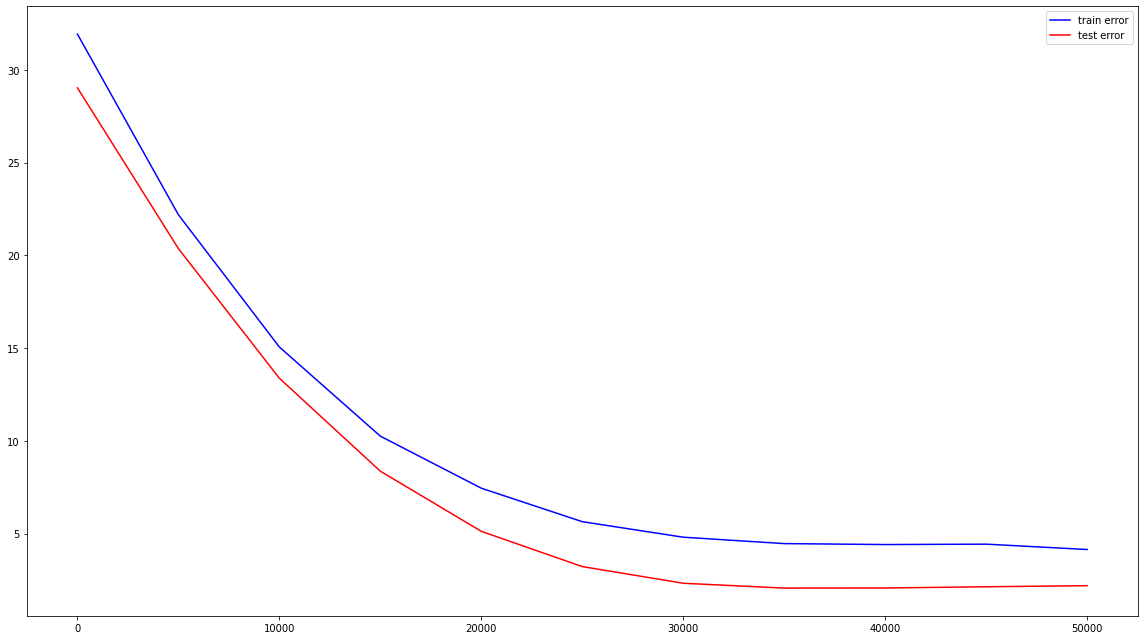

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax_loss = plt.subplot()

model = NeuralNet(nn_arch)

dataset = form_dataset('prodactivity_c/hec', batch_size=batch_size)
agent = AgentFieldDes(model, dataset)
agent.fit()

print(f"#######################################################################\n")
for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")
print(f"#######################################################################\n")

###### total_frame_loss_g

epoch #2000 of 20000 (10.00%)
test dataset error: 3.350353479385376

epoch #4000 of 20000 (20.00%)
test dataset error: 2.8332180976867676

epoch #6000 of 20000 (30.00%)
test dataset error: 2.416653633117676

epoch #8000 of 20000 (40.00%)
test dataset error: 2.0905888080596924

epoch #10000 of 20000 (50.00%)
test dataset error: 1.8459450006484985

epoch #12000 of 20000 (60.00%)
test dataset error: 1.6731805801391602

epoch #14000 of 20000 (70.00%)
test dataset error: 1.562159538269043

epoch #16000 of 20000 (80.00%)
test dataset error: 1.500480055809021

epoch #18000 of 20000 (90.00%)
test dataset error: 1.4756745100021362

epoch #20000 of 20000 (100.00%)
test dataset error: 1.4760783910751343

#######################################################################

epoch:	20000
train dataset error:	3.180316209793091
test dataset error:	1.4923421144485474
batch size:	8
optim state:	{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}}, 'par

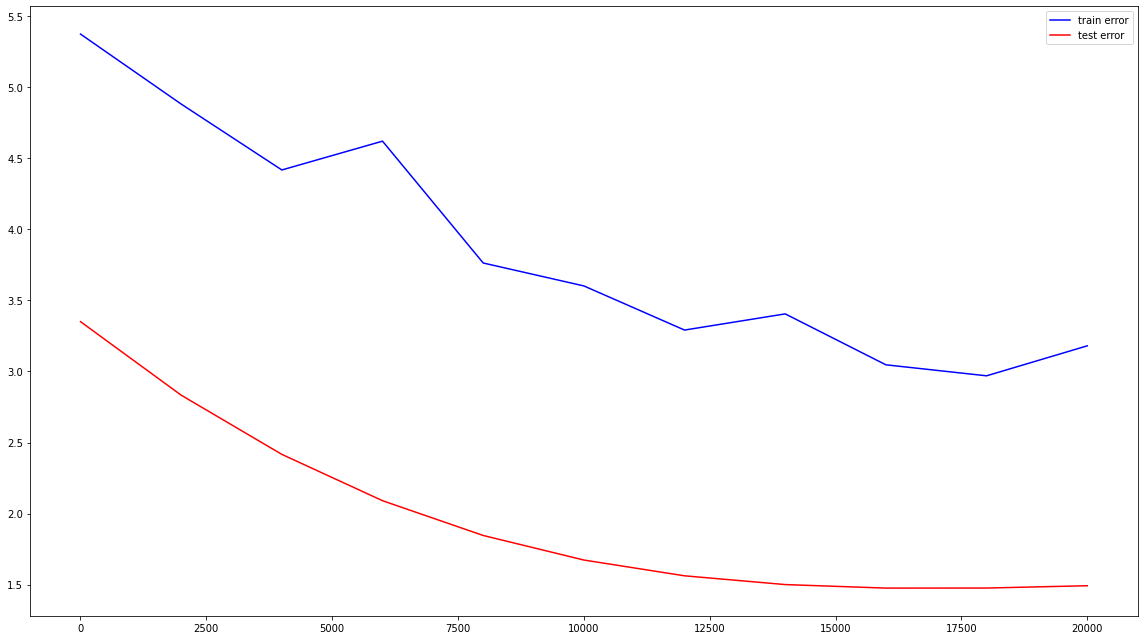

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax_loss = plt.subplot()

model = NeuralNet(nn_arch)

dataset = form_dataset('total_frame_loss_g', batch_size=batch_size)
agent = AgentFieldDes(model, dataset)
agent.fit()

print(f"#######################################################################\n")
for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")
print(f"#######################################################################\n")

###### loss_kg/hec

epoch #1750 of 17500 (10.00%)
test dataset error: 3.6259140968322754

epoch #3500 of 17500 (20.00%)
test dataset error: 3.1465704441070557

epoch #5250 of 17500 (30.00%)
test dataset error: 2.7453255653381348

epoch #7000 of 17500 (40.00%)
test dataset error: 2.4143688678741455

epoch #8750 of 17500 (50.00%)
test dataset error: 2.148242950439453

epoch #10500 of 17500 (60.00%)
test dataset error: 1.9404890537261963

epoch #12250 of 17500 (70.00%)
test dataset error: 1.7848320007324219

epoch #14000 of 17500 (80.00%)
test dataset error: 1.6747547388076782

epoch #15750 of 17500 (90.00%)
test dataset error: 1.6024742126464844

epoch #17500 of 17500 (100.00%)
test dataset error: 1.5606318712234497

#######################################################################

epoch:	17500
train dataset error:	2.9577226638793945
test dataset error:	1.541670799255371
batch size:	8
optim state:	{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}}, 'p

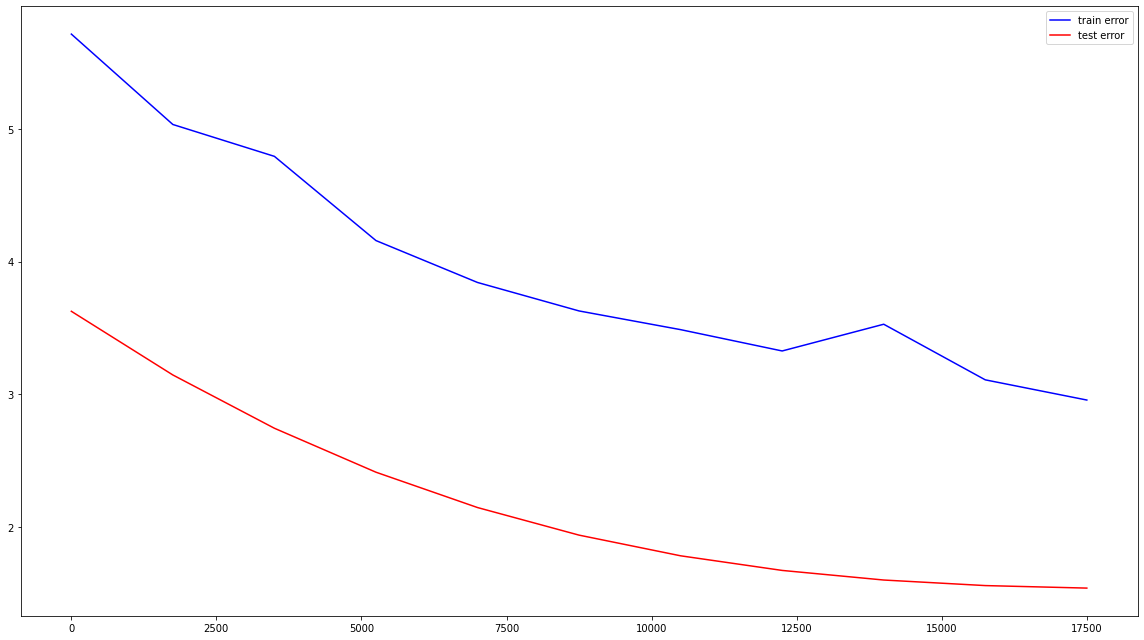

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax_loss = plt.subplot()

model = NeuralNet(nn_arch)

dataset = form_dataset('total_frame_loss_g', batch_size=batch_size)
agent = AgentFieldDes(model, dataset)
agent.fit()

print(f"#######################################################################\n")
for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")
print(f"#######################################################################\n")

###### loss_%/hec

epoch #1750 of 17500 (10.00%)
test dataset error: 1.3328148126602173

epoch #3500 of 17500 (20.00%)
test dataset error: 1.1951133012771606

epoch #5250 of 17500 (30.00%)
test dataset error: 1.0786747932434082

epoch #7000 of 17500 (40.00%)
test dataset error: 0.9811579585075378

epoch #8750 of 17500 (50.00%)
test dataset error: 0.9004603028297424

epoch #10500 of 17500 (60.00%)
test dataset error: 0.8348627686500549

epoch #12250 of 17500 (70.00%)
test dataset error: 0.7823543548583984

epoch #14000 of 17500 (80.00%)
test dataset error: 0.741004467010498

epoch #15750 of 17500 (90.00%)
test dataset error: 0.7091472148895264

epoch #17500 of 17500 (100.00%)
test dataset error: 0.6851755380630493

#######################################################################

epoch:	17500
train dataset error:	0.9795544147491455
test dataset error:	0.6675838232040405
batch size:	8
optim state:	{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}}, '

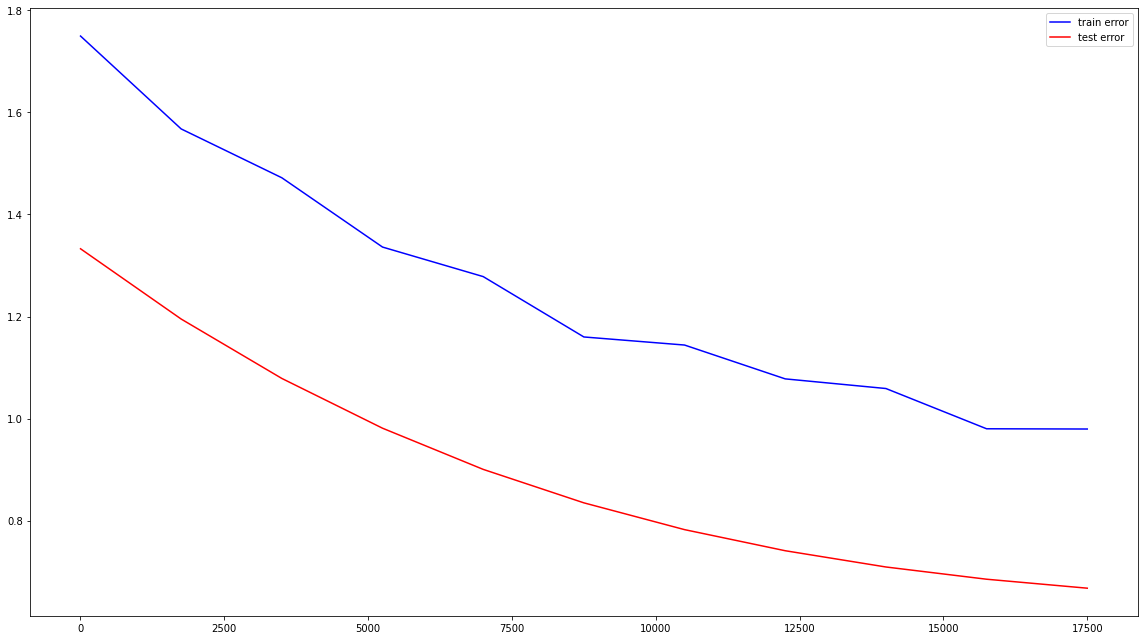

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax_loss = plt.subplot()

model = NeuralNet(nn_arch)

dataset = form_dataset('loss_%/hec', batch_size=batch_size)
agent = AgentFieldDes(model, dataset)
agent.fit()

print(f"#######################################################################\n")
for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")
print(f"#######################################################################\n")

###### loss_kg

epoch #1750 of 17500 (10.00%)
test dataset error: 610.2640380859375

epoch #3500 of 17500 (20.00%)
test dataset error: 521.4074096679688

epoch #5250 of 17500 (30.00%)
test dataset error: 467.6971435546875

epoch #7000 of 17500 (40.00%)
test dataset error: 424.34716796875

epoch #8750 of 17500 (50.00%)
test dataset error: 391.42584228515625

epoch #10500 of 17500 (60.00%)
test dataset error: 362.71533203125

epoch #12250 of 17500 (70.00%)
test dataset error: 339.4865417480469

epoch #14000 of 17500 (80.00%)
test dataset error: 323.5299987792969

epoch #15750 of 17500 (90.00%)
test dataset error: 311.6049499511719

epoch #17500 of 17500 (100.00%)
test dataset error: 306.12286376953125

#######################################################################

epoch:	17500
train dataset error:	1126.3270263671875
test dataset error:	325.56011962890625
batch size:	8
optim state:	{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}}, 'param_group

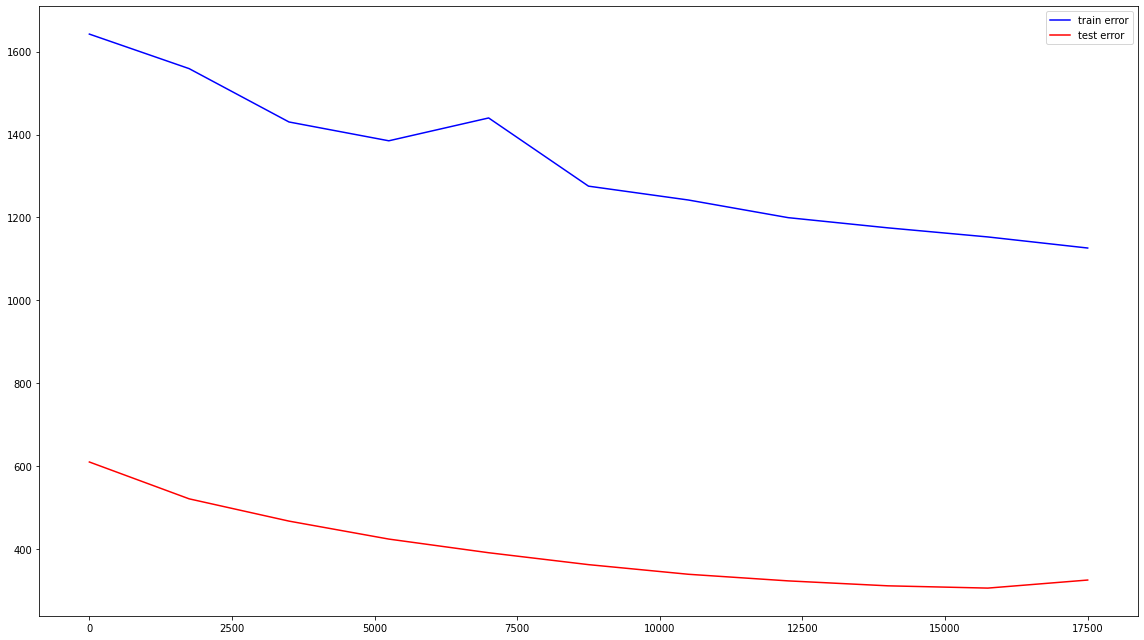

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax_loss = plt.subplot()

model = NeuralNet(nn_arch)

dataset = form_dataset('loss_kg', batch_size=batch_size)
agent = AgentFieldDes(model, dataset)
agent.fit()

print(f"#######################################################################\n")
for key in ['epoch', 'train dataset error', 'test dataset error']:
    print(f"{key}:\t{results[key][-1]}")
print(f"batch size:\t{results['batch size']}\n"
      f"optim state:\t{results['optim state']}\n")
print(f"#######################################################################\n")

##### Висновки

Після тренування моделей було перевірено похибки по кожному таргету по цілому датасету, без поділу на тренувальну та тестову вибірки (метрика - RMSE, значення в дужках - скільки похибка становить від всього діапазону значень параметра у %). Результати такі:

prodactivity_c/hec - 3.935 (20.38%)

total_frame_loss_g - 2.603 (19.43%)

loss_kg/hec - 28.828 (19.38%)

loss_%/hec - 0.845 (18.25%)

loss_kg - 919.756 (13.03%)

Очевидно, точність дуже низька, проте є декілька шляхів для її підвищення

(1) Сітка комбінацій наведених параметрів не покриває усі можливі випадки. Таким чином передбачення у схожих ситуаціях виходять точними, проте якщо на вхід подати дані, які модель "ніколи не бачила", та які навіть не є близькими до вже розглянутих ситуацій, похибка буде значно більшою, як у прикладі y = cos(x) в точках, що лежать далеко від наведених. Тому перший і основний пункт - збільшення датасету з наведенням усіх можливих варіантів

Якщо з точки зору агрономії по наведеним критеріям дійсно можна точно передбачити втрати врожаю, модель виконуватиме цю задачу, але потрібно більше даних

(2) Також можна сформувати рейтинг полів zone та region, засновуючись на експертних оцінках та включити його у вхідні дані

Тренування з цими даними показало, що призначення чисел кожному класу (жовта зона - 1, червона зона - 2; Луганська обл. - 1, Полтавська обл. - 2 і тд) призводить лише до погіршення результатів. Важливо, щоб ці числові ознаки були осмисленими, а не випадковими

(3) Було проведено тренування з різними варіаціями вхідних даних: з видаленням стовпчиків field_square, frame_number і тд. Виявилось, що найкращі результати дає повна вибірка, а при видаленні навіть одного поля похибка збільшується в декілька разів. Іноді в десятки

Тому більшість полів є дуже важливими, видалення лише одного може призвести до значного зменшення точності прогнозу

Тим не менш, на початку EDA аналізу було видалено стовпчики

seeding_date

desication_date

seed_specific_weight_kg/HL

hybrid

locality

district

harvesting_date

та таргет стовпчик total_field_loss через велику кількість порожніх значень (в основному їх було більше половини, їх використання призвело б лише до погіршення результатів)

Очевидно, що ці вхідні дані є дуже важливими для точності прогнозу, а звʼязок між вхідними даними та прогнозованим полем total_field_loss міг би пояснити багато залежностей. Для покращення прогнозу можна поповнити датасет новими даними, що містять ці поля та побудувати нову модель, спираючись на них